# Extractive Question Answering with Transformers

This notebook demonstrates how to apply a Transformer-based architecture to the task of extractive question answering. I'll fine-tune a pre-trained model to identify answer spans within a given context.

**By the end of this notebook, I'll be able to:**

- Perform extractive question answering using a custom dataset  
- Fine-tune a transformer model using both TensorFlow and PyTorch  
- Evaluate and visualize model predictions, logits, and token-level accuracy


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display, HTML

from datasets import load_from_disk

import tensorflow as tf

from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForQuestionAnswering
from transformers import Trainer, TrainingArguments
from transformers import DistilBertForQuestionAnswering

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

import torch
from torch.utils.data import DataLoader

## 1 - Extractive Question Answering

Extractive question answering (QA) is a natural language processing task where the model identifies the span of text that directly answers a given question. For example, given the question *"When will Jane go to Africa?"* and the text *"Jane visits Africa in September"*, the correct model output would be *"September"*.

In this project:

- A pre-trained Transformer model is fine-tuned to answer questions based on short stories.
- The model is implemented and evaluated in both TensorFlow and PyTorch.
- Additional visualizations are included to inspect token-level predictions and model behavior.

### Data Preprocessing

The dataset used is a variation of the [bAbI QA dataset](https://research.fb.com/downloads/babi/), created by Facebook AI Research. The following cells handle loading and preprocessing the data into a suitable format for model training.



In [2]:
# Load a dataset and print the first example in the training set
babi_dataset = load_from_disk('C:/Users/mattg/Downloads/Transformers_project/data/qa/')
print(babi_dataset['train'][0])

{'story': {'answer': ['', '', 'office'], 'id': ['1', '2', '3'], 'supporting_ids': [[], [], ['1']], 'text': ['The office is north of the kitchen.', 'The garden is south of the kitchen.', 'What is north of the kitchen?'], 'type': [0, 0, 1]}}


Let's examine the structure of the dataset. Each example includes two context sentences (the "story") followed by one question. Every sentence and question is tagged with an ID for reference.

Additionally, there's a "supporting fact ID" that points to the specific sentence in the story which contains the information needed to answer the question. For instance, if the question is *"What is east of the hallway?"*, the relevant sentence might be *"The bedroom is east of the hallway"*, labeled with the ID `"2"`. The answer in this case would be *"bedroom"*.


In [3]:
babi_dataset['train'][102]

{'story': {'answer': ['', '', 'bedroom'],
  'id': ['1', '2', '3'],
  'supporting_ids': [[], [], ['2']],
  'text': ['The bedroom is west of the office.',
   'The bedroom is east of the hallway.',
   'What is east of the hallway?'],
  'type': [0, 0, 1]}}

Check now to see if the whole dataset of stories has this format

In [4]:
type_set = set()
for story in babi_dataset['train']:
    if str(story['story']['type'] )not in type_set:
        type_set.add(str(story['story']['type'] ))

In [5]:
type_set

{'[0, 0, 1]'}

Flatten the dataset to transform it from a dictionary structure to a table structure

In [6]:
flattened_babi = babi_dataset.flatten()

In [7]:
flattened_babi

DatasetDict({
    train: Dataset({
        features: ['story.answer', 'story.id', 'story.supporting_ids', 'story.text', 'story.type'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['story.answer', 'story.id', 'story.supporting_ids', 'story.text', 'story.type'],
        num_rows: 1000
    })
})

In [8]:
next(iter(flattened_babi['train']))

{'story.answer': ['', '', 'office'],
 'story.id': ['1', '2', '3'],
 'story.supporting_ids': [[], [], ['1']],
 'story.text': ['The office is north of the kitchen.',
  'The garden is south of the kitchen.',
  'What is north of the kitchen?'],
 'story.type': [0, 0, 1]}

Now it's easier to access the info needed in order to extract the answer, question, and facts from the story. Also, it makes it easier to join the facts into a single entry under 'sentences'.

In [9]:
def get_question_and_facts(story):
    dic = {}
    dic['question'] = story['story.text'][2]
    dic['sentences'] = ' '.join([story['story.text'][0], story['story.text'][1]])
    dic['answer'] = story['story.answer'][2]
    return dic

In [10]:
processed = flattened_babi.map(get_question_and_facts)

In [11]:
processed['train'][2]

{'story.answer': ['', '', 'bedroom'],
 'story.id': ['1', '2', '3'],
 'story.supporting_ids': [[], [], ['2']],
 'story.text': ['The garden is north of the office.',
  'The bedroom is north of the garden.',
  'What is north of the garden?'],
 'story.type': [0, 0, 1],
 'question': 'What is north of the garden?',
 'sentences': 'The garden is north of the office. The bedroom is north of the garden.',
 'answer': 'bedroom'}

In [12]:
processed['test'][2]

{'story.answer': ['', '', 'bathroom'],
 'story.id': ['1', '2', '3'],
 'story.supporting_ids': [[], [], ['1']],
 'story.text': ['The bathroom is north of the garden.',
  'The hallway is north of the bathroom.',
  'What is north of the garden?'],
 'story.type': [0, 0, 1],
 'question': 'What is north of the garden?',
 'sentences': 'The bathroom is north of the garden. The hallway is north of the bathroom.',
 'answer': 'bathroom'}

In extractive question answering, the objective is to locate the exact span of text within the context that answers the question. This requires determining the start and end character indices of the answer within the input string.

For example, given the context *"Jane visits Africa in September."* and the answer *"September"*, the model should identify the character positions where that word begins and ends in the sentence.

The following function is used to compute these character-level start and end indices for each example in the dataset.


In [13]:
def get_start_end_idx(story):
    str_idx = story['sentences'].find(story['answer'])
    end_idx = str_idx + len(story['answer'])
    return {'str_idx':str_idx,
          'end_idx': end_idx}

In [14]:
processed = processed.map(get_start_end_idx)

In [15]:
num = 187
print(processed['test'][num])
start_idx = processed['test'][num]['str_idx']
end_idx = processed['test'][num]['end_idx']
print('answer:', processed['test'][num]['sentences'][start_idx:end_idx])

{'story.answer': ['', '', 'garden'], 'story.id': ['1', '2', '3'], 'story.supporting_ids': [[], [], ['2']], 'story.text': ['The hallway is south of the garden.', 'The garden is south of the bedroom.', 'What is south of the bedroom?'], 'story.type': [0, 0, 1], 'question': 'What is south of the bedroom?', 'sentences': 'The hallway is south of the garden. The garden is south of the bedroom.', 'answer': 'garden', 'str_idx': 28, 'end_idx': 34}
answer: garden


### Tokenization and Alignment with Hugging Face

With your dataset prepared, the next step is to tokenize the input so it can be used by a Transformer model. This involves converting the question and context into token IDs using a tokenizer that matches the model architecture.

In this project, the DistilBERT fast tokenizer from the Hugging Face Transformers library is used. It handles padding and truncation, and converts input text into a standardized token sequence, typically up to 512 tokens.

Since Transformer tokenizers often split words into subword units (e.g., *"Africa"* might become *"Af" + "##rica"*), it’s important to correctly align the character-level answer indices with the corresponding token indices. This ensures that the model can learn to predict the exact start and end positions of the answer span in the tokenized sequence.

The function you'll use next performs this alignment so that each training example includes tokenized input along with accurate start and end token positions for the answer.


In [16]:
tokenizer = DistilBertTokenizerFast.from_pretrained('C:/Users/mattg/Downloads/Transformers_project/tokenizers/qa')

In [17]:
def tokenize_align(example):
    encoding = tokenizer(example['sentences'], example['question'], truncation=True, padding=True, max_length=tokenizer.model_max_length)
    start_positions = encoding.char_to_token(example['str_idx'])
    end_positions = encoding.char_to_token(example['end_idx']-1)
    if start_positions is None:
        start_positions = tokenizer.model_max_length
    if end_positions is None:
        end_positions = tokenizer.model_max_length
    return {'input_ids': encoding['input_ids'],
          'attention_mask': encoding['attention_mask'],
          'start_positions': start_positions,
          'end_positions': end_positions}

In [18]:
qa_dataset = processed.map(tokenize_align)

In [19]:
qa_dataset = qa_dataset.remove_columns(['story.answer', 'story.id', 'story.supporting_ids', 'story.text', 'story.type'])

In [20]:
qa_dataset['train'][200]

{'question': 'What is north of the bathroom?',
 'sentences': 'The garden is north of the bathroom. The hallway is south of the bathroom.',
 'answer': 'garden',
 'str_idx': 4,
 'end_idx': 10,
 'input_ids': [101,
  1996,
  3871,
  2003,
  2167,
  1997,
  1996,
  5723,
  1012,
  1996,
  6797,
  2003,
  2148,
  1997,
  1996,
  5723,
  1012,
  102,
  2054,
  2003,
  2167,
  1997,
  1996,
  5723,
  1029,
  102],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'start_positions': 2,
 'end_positions': 2}

## 2 - Model Training

With the input data tokenized and aligned, you're ready to fine-tune a pre-trained Transformer model for the question answering task. The model used here is DistilBERT, which is compatible with the tokenizer applied during preprocessing.

This step involves feeding the processed input into the model and training it to predict the correct start and end positions of the answer span within the context.


In [21]:
train_ds = qa_dataset['train']
test_ds = qa_dataset['test']

In [22]:
model = TFDistilBertForQuestionAnswering.from_pretrained("C:/Users/mattg/Downloads/Transformers_project/models/qa/tensorflow", return_dict=False)

All model checkpoint layers were used when initializing TFDistilBertForQuestionAnswering.

All the layers of TFDistilBertForQuestionAnswering were initialized from the model checkpoint at C:/Users/mattg/Downloads/Transformers_project/models/qa/tensorflow.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForQuestionAnswering for predictions without further training.


### TensorFlow Implementation

In this section, you'll train the question answering model using TensorFlow.

#### Preparing the Train and Test Datasets

Before training, you'll need to configure the dataset format to work with TensorFlow. This includes converting the tokenized inputs and labels into tensors.

**Important notes:**
- When converting the data to tensors, sequences may have varying lengths, resulting in ragged tensors.
- These ragged tensors need to be padded to uniform length using the `to_tensor()` method. This step ensures all input batches conform to the model's expected shape, typically `[None, tokenizer.model_max_length]`.

Once the data is properly formatted, you can begin training using the DistilBERT model.

In [23]:
columns_to_return = ['input_ids','attention_mask', 'start_positions', 'end_positions']

train_ds.set_format(type='tf', columns=columns_to_return)

train_features = {x: train_ds[x] for x in ['input_ids', 'attention_mask']}
train_labels = {"start_positions": tf.reshape(train_ds['start_positions'], shape=[-1,1]),
                'end_positions': tf.reshape(train_ds['end_positions'], shape=[-1,1])}


train_tfdataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).batch(8)

#### Training the Model

Now that the dataset is prepared, you can begin training the model.

- A custom training loop is defined using `tf.GradientTape()`, which enables manual control over the training process.
- The model outputs two sets of logits: one for the start position and one for the end position of the answer span.
- Separate loss functions are applied to each set of logits.
- `tf.GradientTape()` automatically tracks operations during the forward pass, allowing gradients to be computed and applied during backpropagation.

This approach offers flexibility in managing model updates and monitoring custom metrics during training.


In [24]:
EPOCHS = 3
loss_fn1 = tf.keras.losses.SparseCategoricalCrossentropy( from_logits=True)
loss_fn2 = tf.keras.losses.SparseCategoricalCrossentropy( from_logits=True)
opt = tf.keras.optimizers.Adam(learning_rate=3e-5)

losses = []
for epoch in range(EPOCHS):
    print("Starting epoch: %d"% epoch )
    for step, (x_batch_train, y_batch_train) in enumerate(train_tfdataset):
        with tf.GradientTape() as tape:
            answer_start_scores, answer_end_scores = model(x_batch_train)
            loss_start = loss_fn1(y_batch_train['start_positions'], answer_start_scores)
            loss_end = loss_fn2(y_batch_train['end_positions'], answer_end_scores)
            loss = 0.5 * (loss_start + loss_end)
        losses.append(loss)
        grads = tape.gradient(loss, model.trainable_weights)
        opt.apply_gradients(zip(grads, model.trainable_weights))

        if step % 20 == 0:
            print("Training loss (for one batch) at step %d: %.4f"% (step, 
                                                                   float(loss_start)))


Starting epoch: 0
Training loss (for one batch) at step 0: 3.3658
Training loss (for one batch) at step 20: 1.2483
Training loss (for one batch) at step 40: 0.5979
Training loss (for one batch) at step 60: 0.6204
Training loss (for one batch) at step 80: 0.5239
Training loss (for one batch) at step 100: 0.0897
Training loss (for one batch) at step 120: 0.5420
Starting epoch: 1
Training loss (for one batch) at step 0: 0.6697
Training loss (for one batch) at step 20: 0.2519
Training loss (for one batch) at step 40: 0.5088
Training loss (for one batch) at step 60: 0.3312
Training loss (for one batch) at step 80: 0.1340
Training loss (for one batch) at step 100: 0.0931
Training loss (for one batch) at step 120: 0.4568
Starting epoch: 2
Training loss (for one batch) at step 0: 0.3099
Training loss (for one batch) at step 20: 0.0838
Training loss (for one batch) at step 40: 0.5054
Training loss (for one batch) at step 60: 0.2983
Training loss (for one batch) at step 80: 0.1146
Training loss 

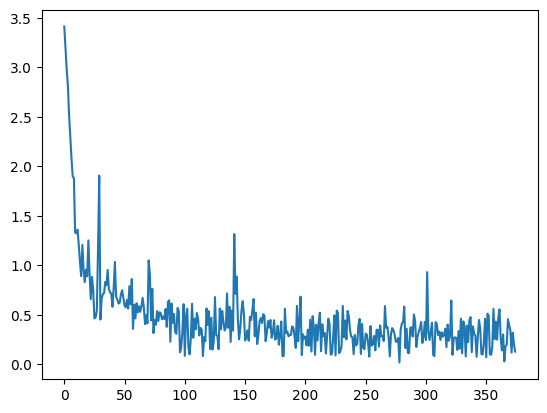

In [25]:
plt.plot(losses)
plt.show()

### Evaluating Predictions with EM and F1 Score

To evaluate the quality of the model's predictions, this section introduces a function that computes two standard extractive QA metrics:

- **Exact Match (EM):** Returns 1 if the predicted answer matches the true answer exactly (ignoring case and whitespace).
- **F1 Score:** Measures the overlap between the predicted and actual answer tokens, providing a more forgiving score based on precision and recall.

The example below demonstrates this evaluation on a single input. If the exact match fails, the output is flagged for further inspection.


In [26]:
def compute_em_and_f1(pred_text, true_text):
    def normalize_text(s):
        return s.strip().lower()

    pred_tokens = normalize_text(pred_text).split()
    true_tokens = normalize_text(true_text).split()

    # Exact Match
    exact_match = int(normalize_text(pred_text) == normalize_text(true_text))

    # F1 Score
    common = set(pred_tokens) & set(true_tokens)
    if len(common) == 0:
        return exact_match, 0.0

    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(true_tokens)
    f1 = 2 * (precision * recall) / (precision + recall)

    return exact_match, f1


In [27]:
question, text = 'What is south of the bedroom?', 'The hallway is south of the garden. The garden is south of the bedroom.'
input_dict = tokenizer(text, question, return_tensors='tf')
outputs = model(input_dict)

start_logits = outputs[0]
end_logits = outputs[1]

all_tokens = tokenizer.convert_ids_to_tokens(input_dict["input_ids"].numpy()[0])
start_idx = tf.math.argmax(start_logits, 1)[0].numpy()
end_idx = tf.math.argmax(end_logits, 1)[0].numpy()

answer = tokenizer.convert_tokens_to_string(all_tokens[start_idx : end_idx + 1])
gold = 'garden' # known true answer for this example

em, f1 = compute_em_and_f1(answer, gold)
print(f"Q: {question}\nPredicted: {answer}\nGold: {gold}\nEM: {em} | F1: {f1:.2f}")

if em == 0:
    print("Failed prediction!")


Q: What is south of the bedroom?
Predicted: garden
Gold: garden
EM: 1 | F1: 1.00


### Visualizing Logit Distributions with a Heatmap

To better understand how the model identifies the answer span, the softmax-normalized logits for start and end positions can be visualized as heatmaps. These plots show the model's confidence distribution across all input tokens for a given question-context pair.

The heatmap highlights:
- Which tokens the model is most likely to choose as the start of the answer
- Which tokens it believes mark the end of the answer

This visualization is useful for interpreting model behavior and diagnosing mispredictions.


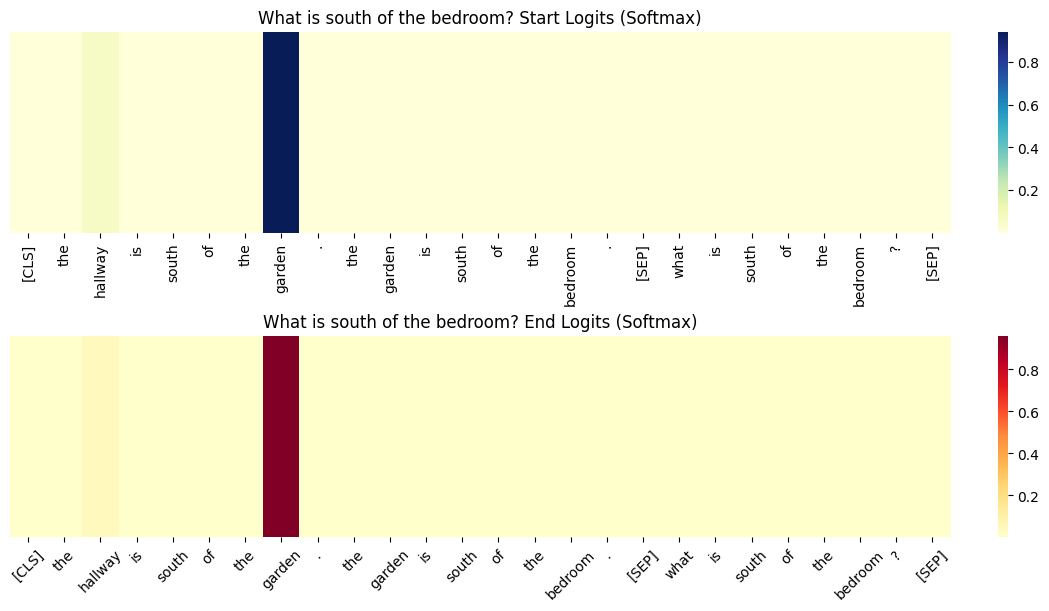

In [28]:
def plot_qa_heatmap_tf(input_ids, start_logits, end_logits, tokenizer, title_prefix=""):

    tokens = tokenizer.convert_ids_to_tokens(input_ids.numpy()[0])

    start_probs = tf.nn.softmax(start_logits[0]).numpy()
    end_probs = tf.nn.softmax(end_logits[0]).numpy()

    fig, axs = plt.subplots(2, 1, figsize=(len(tokens) * 0.4, 6), constrained_layout=True)

    sns.heatmap([start_probs], xticklabels=tokens, cmap='YlGnBu', ax=axs[0])
    axs[0].set_title(f'{title_prefix} Start Logits (Softmax)')
    axs[0].set_yticks([])

    sns.heatmap([end_probs], xticklabels=tokens, cmap='YlOrRd', ax=axs[1])
    axs[1].set_title(f'{title_prefix} End Logits (Softmax)')
    axs[1].set_yticks([])

    plt.xticks(rotation=45)
    plt.show()

question = "What is south of the bedroom?"
text = "The hallway is south of the garden. The garden is south of the bedroom."
input_dict = tokenizer(text, question, return_tensors='tf')

outputs = model(input_dict)
start_logits, end_logits = outputs

plot_qa_heatmap_tf(input_dict["input_ids"], start_logits, end_logits, tokenizer, title_prefix=question)


### Evaluating Token-Level Accuracy with Confusion Matrices

To assess how accurately the model predicts the token positions of the answer, confusion matrices are generated for both start and end indices.

Each matrix compares the predicted token positions to the true positions across all test samples. High values along the diagonal indicate that the model frequently predicts the correct token. Off-diagonal values highlight where the model tends to mispredict.

The printed output below the loop also shows specific failure cases for further analysis.


Q: What is the bathroom east of?
Context: The hallway is east of the bathroom. The bedroom is west of the bathroom.
Predicted: hallway | Gold: bedroom

Q: What is the bedroom north of?
Context: The kitchen is north of the bedroom. The garden is south of the bedroom.
Predicted: kitchen | Gold: garden

Q: What is the office east of?
Context: The hallway is east of the office. The garden is west of the office.
Predicted: hallway | Gold: garden

Q: What is the bathroom south of?
Context: The kitchen is south of the bathroom. The garden is north of the bathroom.
Predicted: kitchen | Gold: garden

Q: What is north of the bedroom?
Context: The kitchen is south of the bedroom. The bathroom is north of the bedroom.
Predicted: kitchen | Gold: bathroom

Q: What is the office south of?
Context: The garden is north of the office. The hallway is south of the office.
Predicted: hallway | Gold: garden

Q: What is the office south of?
Context: The garden is north of the office. The hallway is south of 

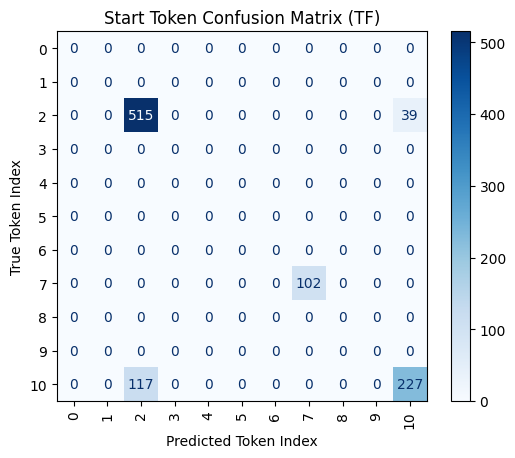

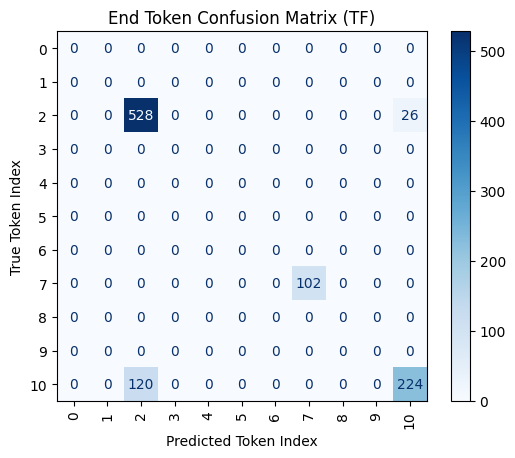

In [29]:
def plot_token_confusion_matrix(true_positions, pred_positions, title="Start Token Confusion Matrix"):
    cm = confusion_matrix(true_positions, pred_positions, labels=range(0, max(true_positions + pred_positions) + 1))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', xticks_rotation=90)
    plt.title(title)
    plt.xlabel("Predicted Token Index")
    plt.ylabel("True Token Index")
    plt.show()

tokenized_test = qa_dataset['test']
raw_test = processed['test']

true_starts = []
pred_starts = []
true_ends = []
pred_ends = []

tokenized_test = qa_dataset['test']
raw_test = processed['test']

for tok_ex, raw_ex in zip(tokenized_test, raw_test):
    question = raw_ex['question']
    context = raw_ex['sentences']
    gold_start = tok_ex['start_positions']
    gold_end = tok_ex['end_positions']

    inputs = tokenizer(context, question, return_tensors='tf', truncation=True)

    outputs = model(inputs)
    start_logits, end_logits = outputs

    pred_start = tf.argmax(start_logits, axis=-1).numpy()[0]
    pred_end = tf.argmax(end_logits, axis=-1).numpy()[0]

    true_starts.append(gold_start)
    pred_starts.append(pred_start)
    true_ends.append(gold_end)
    pred_ends.append(pred_end)

    if gold_start != pred_start or gold_end != pred_end:
        tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'].numpy()[0])
        pred_ans = tokenizer.convert_tokens_to_string(tokens[pred_start: pred_end + 1])
        print(f"Q: {question}\nContext: {context}\nPredicted: {pred_ans} | Gold: {raw_ex['answer']}\n")


plot_token_confusion_matrix(true_starts, pred_starts, title="Start Token Confusion Matrix (TF)")
plot_token_confusion_matrix(true_ends, pred_ends, title="End Token Confusion Matrix (TF)")

### Visualizing Predictions with Colored Answer Highlights

This section adds an interactive visualization to compare the model's predicted answer span with the actual (ground truth) answer in the original context text.

The implementation uses HTML to highlight:
- ✅ The correct answer span (in **green**)
- 🟨 The model’s predicted answer span (in **yellow**)

This tool is helpful for debugging and visually inspecting how well the model is identifying the correct portion of the text. It also makes discrepancies between the predicted and actual answers immediately obvious, especially in failure cases.

In [30]:
def highlight_answer(text, start_idx, end_idx, pred_start_idx=None, pred_end_idx=None):
    html = ""
    for i, c in enumerate(text):
        if pred_start_idx is not None and i == pred_start_idx:
            html += '<span style="background-color: #ffd966;">'  # Predicted highlight start
        if i == start_idx:
            html += '<span style="background-color: #a9dfbf;">'  # Gold highlight start

        html += c

        if i == end_idx - 1:
            html += '</span>'  # Gold highlight end
        if pred_end_idx is not None and i == pred_end_idx - 1:
            html += '</span>'  # Predicted highlight end

    return HTML(html)

example = processed['test'][187]
text = example['sentences']
question = example['question']
gold_answer = example['answer']
true_start = example['str_idx']
true_end = example['end_idx']

input_dict = tokenizer(text, question, return_tensors='tf')
outputs = model(input_dict)
start = tf.argmax(outputs[0], axis=-1).numpy()[0]
end = tf.argmax(outputs[1], axis=-1).numpy()[0]

offsets = tokenizer(text, question, return_offsets_mapping=True)['offset_mapping']

try:
    pred_char_start = offsets[start][0]
    pred_char_end = offsets[end][1]
except IndexError:
    pred_char_start = pred_char_end = -1

print(f"Q: {question}")
display(highlight_answer(text, start_idx=true_start, end_idx=true_end,
                         pred_start_idx=pred_char_start, pred_end_idx=pred_char_end))

Q: What is south of the bedroom?


## PyTorch Implementation

This section demonstrates how to fine-tune the same question answering model using the PyTorch framework.

#### Preparing the Train and Test Datasets

The tokenized inputs and labels are converted into PyTorch tensors to prepare the dataset for training and evaluation. This setup allows the use of PyTorch’s native training loop or the Hugging Face `Trainer` API for more structured model training.



In [31]:
columns_to_return = ['input_ids','attention_mask', 'start_positions', 'end_positions']
train_ds.set_format(type='pt', columns=columns_to_return)
test_ds.set_format(type='pt', columns=columns_to_return)

### Accuracy Metrics for PyTorch Evaluation

For the PyTorch implementation, the evaluation process uses the **F1 score** to assess how accurately the model predicts the start and end positions of the answer across the entire test set.

Instead of tracking loss alone, F1 scores for the start and end token positions are calculated using the predicted and true labels. This provides a clearer picture of how well the model performs in locating the correct answer spans.


In [32]:
def compute_metrics(pred):
    start_labels = pred.label_ids[0]
    start_preds = pred.predictions[0].argmax(-1)
    end_labels = pred.label_ids[1]
    end_preds = pred.predictions[1].argmax(-1)
    
    f1_start = f1_score(start_labels, start_preds, average='macro')
    f1_end = f1_score(end_labels, end_preds, average='macro')
    
    return {'f1_start': f1_start, 'f1_end': f1_end}

#### Model Training

With the dataset prepared, the next step is to load and fine-tune a pre-trained model using PyTorch.

**Note:**  
For this implementation, the standard `DistilBERT` model from Hugging Face's Transformers library is used (not the TensorFlow variant). This model is compatible with PyTorch and allows for direct integration with the Hugging Face `Trainer` API for training and evaluation.


In [33]:
del model #delete TF model to free up memory

In [34]:
pytorch_model = DistilBertForQuestionAnswering.from_pretrained("C:/Users/mattg/Downloads/Transformers_project/models/qa/pytorch")

### Training with the Hugging Face Trainer API

Rather than building a custom training loop, this implementation uses the Hugging Face `Trainer` class, which provides a convenient and modular way to fine-tune models in PyTorch.

The `Trainer` handles batching, optimization, evaluation, and logging, making it easy to manage the training process with minimal boilerplate code.


In [35]:
training_args = TrainingArguments(output_dir='results', # output directory
                                  overwrite_output_dir=True,
                                  num_train_epochs=3, # total number of training epochs
                                  per_device_train_batch_size=8, # batch size per device during training
                                  per_device_eval_batch_size=8, # batch size for evaluation
                                  warmup_steps=20, # number of warmup steps for learning rate scheduler
                                  weight_decay=0.01, # strength of weight decay
                                  logging_dir=None, # directory for storing logs
                                  logging_steps=50)

trainer = Trainer(model=pytorch_model, # the instantiated 🤗 Transformers model to be trained
                  args=training_args, # training arguments, defined above
                  train_dataset=train_ds, # training dataset
                  eval_dataset=test_ds,
                  compute_metrics=compute_metrics) # evaluation dataset

trainer.train()

Step,Training Loss
50,1.579600
100,0.611000
150,0.538800
200,0.431000
250,0.335000
300,0.338600
350,0.298100


TrainOutput(global_step=375, training_loss=0.570810469309489, metrics={'train_runtime': 82.5314, 'train_samples_per_second': 36.35, 'train_steps_per_second': 4.544, 'total_flos': 19904183208000.0, 'train_loss': 0.570810469309489, 'epoch': 3.0})

In [36]:
trainer.evaluate(test_ds)

{'eval_loss': 0.3106156885623932,
 'eval_f1_start': 0.8163841298258517,
 'eval_f1_end': 0.8132428051503195,
 'eval_runtime': 3.9817,
 'eval_samples_per_second': 251.148,
 'eval_steps_per_second': 31.394,
 'epoch': 3.0}

### Testing the Model on a Sample Question

Once training is complete, the model can be tested by passing in a question and its corresponding context.

- If a GPU is available, the model and inputs are moved to it for faster inference.
- The question and context are tokenized and converted to PyTorch tensors.
- The model predicts the most likely start and end positions of the answer span, which are then decoded back into human-readable text.
- Exact Match (EM) and F1 scores are computed to evaluate the prediction against the ground truth.


In [37]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

pytorch_model.to(device)

question, text = 'What is east of the hallway?', 'The kitchen is east of the hallway. The garden is south of the bedroom.'

input_dict = tokenizer(text, question, return_tensors='pt')
input_ids = input_dict['input_ids'].to(device)
attention_mask = input_dict['attention_mask'].to(device)

outputs = pytorch_model(input_ids, attention_mask=attention_mask)
start_logits = outputs[0]
end_logits = outputs[1]

all_tokens = tokenizer.convert_ids_to_tokens(input_dict["input_ids"].cpu().numpy()[0])
start_idx = torch.argmax(start_logits, 1)[0].item()
end_idx = torch.argmax(end_logits, 1)[0].item()

answer = tokenizer.convert_tokens_to_string(all_tokens[start_idx : end_idx + 1])
gold = 'kitchen'

em, f1 = compute_em_and_f1(answer, gold)
print(f"Q: {question}\nPredicted: {answer.capitalize()}\nGold: {gold}\nEM: {em} | F1: {f1:.2f}")

if em == 0:
    print("Failed prediction!")


Q: What is east of the hallway?
Predicted: Kitchen
Gold: kitchen
EM: 1 | F1: 1.00


### Heatmap of Start/End Logits (Logit Distribution)
This helps visualize where the model is focusing for answer spans.

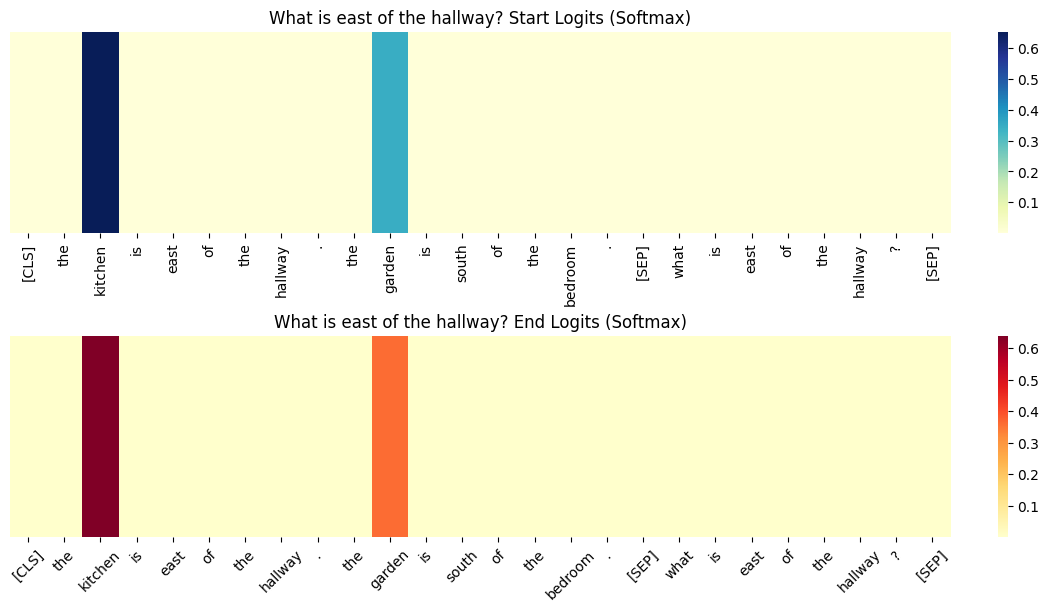

In [ ]:
def plot_qa_heatmap(input_ids, start_logits, end_logits, tokenizer, title_prefix=""):
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].tolist())

    start_probs = start_logits[0].softmax(dim=-1).cpu().detach().numpy()
    end_probs = end_logits[0].softmax(dim=-1).cpu().detach().numpy()

    fig, axs = plt.subplots(2, 1, figsize=(len(tokens) * 0.4, 6), constrained_layout=True)

    sns.heatmap([start_probs], xticklabels=tokens, cmap='YlGnBu', ax=axs[0])
    axs[0].set_title(f'{title_prefix} Start Logits (Softmax)')
    axs[0].set_yticks([])

    sns.heatmap([end_probs], xticklabels=tokens, cmap='YlOrRd', ax=axs[1])
    axs[1].set_title(f'{title_prefix} End Logits (Softmax)')
    axs[1].set_yticks([])

    plt.xticks(rotation=45)
    plt.show()


question = "What is east of the hallway?"
text = "The kitchen is east of the hallway. The garden is south of the bedroom."
input_dict = tokenizer(text, question, return_tensors='pt').to(device)

with torch.no_grad():
    outputs = pytorch_model(**input_dict)

plot_qa_heatmap(input_dict["input_ids"], outputs[0], outputs[1], tokenizer, title_prefix=question)

### Confusion Matrix Between True & Predicted Start/End Positions
This assumes ground truth is token-aligned, which you already did via char_to_token.

Q: What is north of the office?
Context: The hallway is south of the office. The garden is north of the office.
Predicted: hallway | Gold: garden

Q: What is west of the kitchen?
Context: The bathroom is east of the kitchen. The garden is west of the kitchen.
Predicted: bathroom | Gold: garden

Q: What is south of the bathroom?
Context: The office is south of the bathroom. The kitchen is north of the bathroom.
Predicted: kitchen | Gold: office

Q: What is the bedroom north of?
Context: The kitchen is north of the bedroom. The garden is south of the bedroom.
Predicted: kitchen | Gold: garden

Q: What is the kitchen west of?
Context: The garden is east of the kitchen. The bedroom is west of the kitchen.
Predicted: bedroom | Gold: garden

Q: What is the office east of?
Context: The hallway is east of the office. The garden is west of the office.
Predicted: hallway | Gold: garden

Q: What is the bathroom south of?
Context: The kitchen is south of the bathroom. The garden is north of the ba

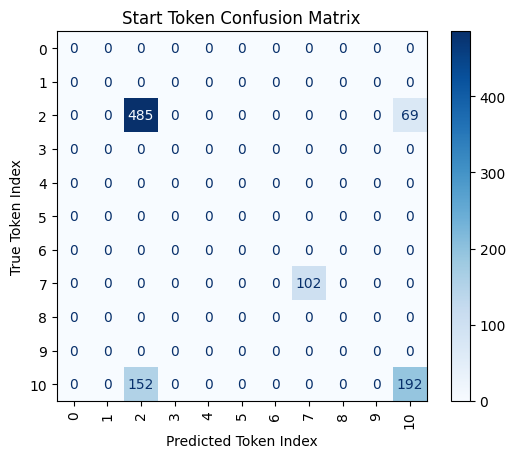

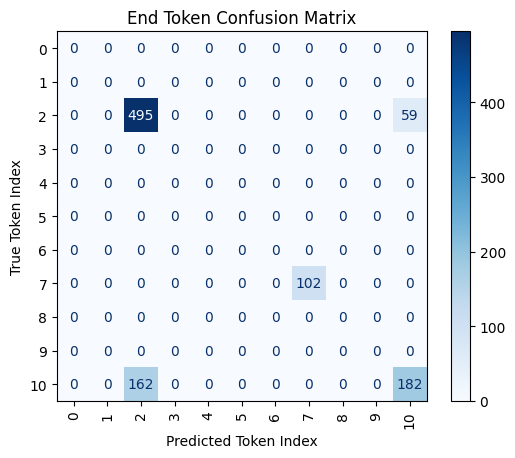

In [ ]:
def plot_token_confusion_matrix(true_positions, pred_positions, title="Start Token Confusion Matrix"):
    cm = confusion_matrix(true_positions, pred_positions, labels=range(0, max(true_positions + pred_positions) + 1))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', xticks_rotation=90)
    plt.title(title)
    plt.xlabel("Predicted Token Index")
    plt.ylabel("True Token Index")
    plt.show()

tokenized_test = qa_dataset['test']
raw_test = processed['test']

true_starts = []
pred_starts = []
true_ends = []
pred_ends = []

for tok_ex, raw_ex in zip(tokenized_test, raw_test):
    question = raw_ex['question']
    context = raw_ex['sentences']
    gold_answer = raw_ex['answer']
    gold_start = tok_ex['start_positions']
    gold_end = tok_ex['end_positions']

    inputs = tokenizer(context, question, return_tensors='pt', truncation=True).to(device)

    with torch.no_grad():
        outputs = pytorch_model(**inputs)
        start_logits = outputs.start_logits
        end_logits = outputs.end_logits

    pred_start = torch.argmax(start_logits, dim=-1).item()
    pred_end = torch.argmax(end_logits, dim=-1).item()

    true_starts.append(gold_start)
    pred_starts.append(pred_start)
    true_ends.append(gold_end)
    pred_ends.append(pred_end)

    # Only print failed predictions
    if gold_start != pred_start or gold_end != pred_end:
        tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
        pred_ans = tokenizer.convert_tokens_to_string(tokens[pred_start : pred_end + 1])
        print(f"Q: {question}\nContext: {context}\nPredicted: {pred_ans} | Gold: {gold_answer}\n")


plot_token_confusion_matrix(true_starts, pred_starts, title="Start Token Confusion Matrix")
plot_token_confusion_matrix(true_ends, pred_ends, title="End Token Confusion Matrix")

### Interactive QA Visualization (Colored HTML Table)
A great way to inspect predictions inline.

In [ ]:
def highlight_answer(text, start_idx, end_idx, pred_start_idx=None, pred_end_idx=None):
    html = ""
    for i, c in enumerate(text):
        if pred_start_idx is not None and i == pred_start_idx:
            html += '<span style="background-color: #ffd966;">'  # Predicted highlight start
        if i == start_idx:
            html += '<span style="background-color: #a9dfbf;">'  # Gold highlight start

        html += c

        if i == end_idx - 1:
            html += '</span>'  # Gold highlight end
        if pred_end_idx is not None and i == pred_end_idx - 1:
            html += '</span>'  # Predicted highlight end

    return HTML(html)

example = processed['test'][187]
text = example['sentences']
question = example['question']
gold_answer = example['answer']
true_start = example['str_idx']
true_end = example['end_idx']

# Run model inference
input_dict = tokenizer(text, question, return_tensors='pt').to(device)
outputs = pytorch_model(**input_dict)
start = torch.argmax(outputs[0], dim=-1)[0].item()
end = torch.argmax(outputs[1], dim=-1)[0].item()

# Convert token positions to char positions (for highlighting)
tokens = input_dict['input_ids'][0]
token_offsets = tokenizer(text, question, return_offsets_mapping=True)['offset_mapping']
token_offsets = token_offsets[:len(tokens)]  # trim if needed

# Handle edge cases
try:
    pred_char_start = token_offsets[start][0]
    pred_char_end = token_offsets[end][1]
except IndexError:
    pred_char_start = pred_char_end = -1

print(f"Q: {question}")
display(highlight_answer(text, start_idx=true_start, end_idx=true_end, pred_start_idx=pred_char_start, pred_end_idx=pred_char_end))

Q: What is south of the bedroom?


### Summary

You've successfully completed this notebook and implemented a Transformer-based model for extractive question answering using both TensorFlow and PyTorch.

By the end of this project, you have:

- Fine-tuned a pre-trained Transformer model on a custom QA dataset  
- Extracted answer spans from context using start and end token positions  
- Implemented training and evaluation pipelines in both TensorFlow and PyTorch  
- Visualized model behavior through logit heatmaps, confusion matrices, and highlighted predictions  
- Applied exact match and F1 metrics to assess performance

#### Key Takeaways:

- Transformer tokenizers often split words into subword units, so aligning character indices to token indices is a crucial preprocessing step.
- TensorFlow offers flexibility through custom training loops using `tf.GradientTape`, which is useful for fine-grained control over model updates.
- PyTorch integrates smoothly with Hugging Face’s `Trainer` API, making it easier to manage training and evaluation with less boilerplate.
- Visualizing model predictions is invaluable for understanding performance and identifying failure cases in extractive QA.
